In [11]:
!nvidia-smi

Mon Sep 13 15:06:46 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 450.119.04   Driver Version: 450.119.04   CUDA Version: 11.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    26W / 250W |      2MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [49]:
import cv2
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision
import torch.nn as nn
from torchvision import transforms
import torch.nn.functional as F
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


## Depth Wise Seprable Convolution

This convolution originated from the idea that depth and spatial dimension of a filter can be separated- thus the name separable. You can separate the height and width dimension of these filters. Gx filter (see fig 3) can be viewed as matrix product of [1 2 1] transpose with [-1 0 1].

that the filter had disguised itself. It shows it had 9 parameters but it has actually 6. This has been possible because of separation of its height and width dimensions. The same idea applied to separate depth dimension from horizontal (width*height) gives us depth-wise separable convolution whare we perform depth-wise convolution and after that we use a 1*1 filter to cover the depth dimension.

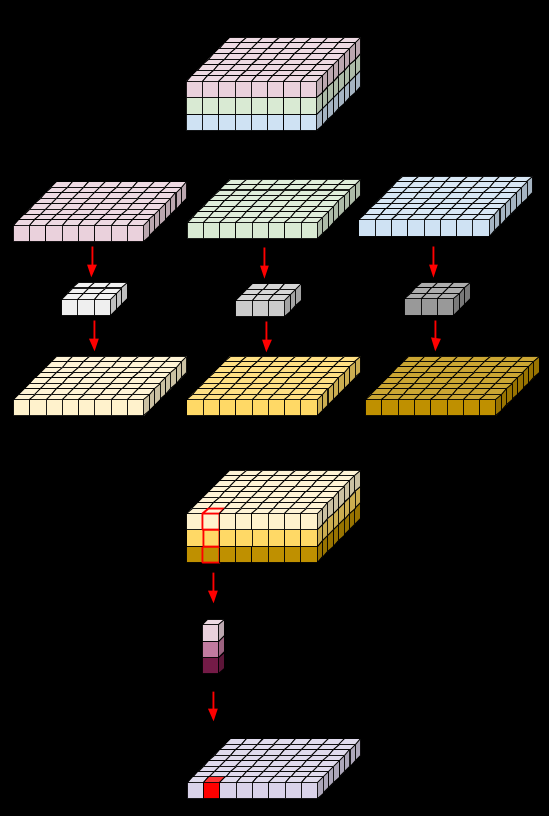

### Torch Implementation Related Documen
`torch.nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros', device=None, dtype=None)`

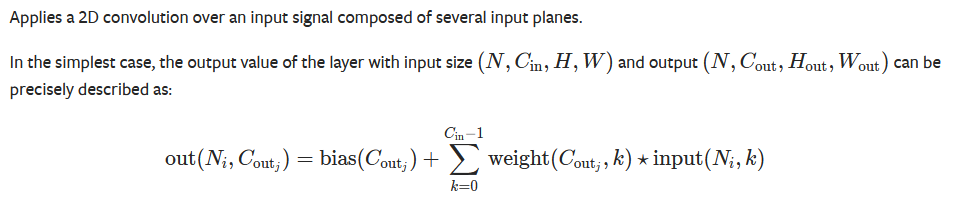

Parameters:
```
stride controls the stride for the cross-correlation, a single number or a tuple.

padding controls the amount of padding applied to the input. It can be either a string {‘valid’, ‘same’} or a tuple of ints giving the amount of implicit padding applied on both sides.

dilation controls the spacing between the kernel points; also known as the à trous algorithm. It is harder to describe, but this link has a nice visualization of what dilation does.

groups controls the connections between inputs and outputs. in_channels and out_channels must both be divisible by groups.
```

In [14]:
class DepthWiseSeprableConv(nn.Module):
    def __init__(self, inSize, kernelPerLayer, outSize):
        super(DepthWiseSeprableConv, self).__init__()
        self.depthwise = nn.Conv2d(inSize, inSize * kernelPerLayer, kernel_size=5, padding=2, groups=inSize)
        self.pointwise = nn.Conv2d(inSize * kernelPerLayer, outSize, kernel_size=1)
        
    def forward(self, x):
        out = self.depthwise(x)
        out = self.pointwise(out)
        return out

## Swish Activation Function
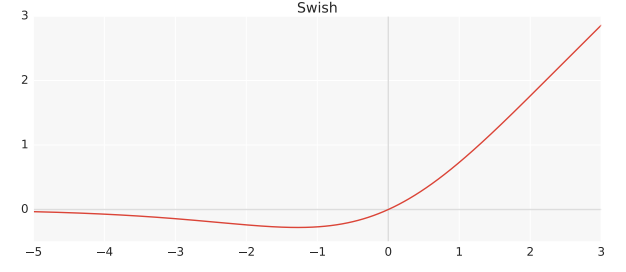

Swish is a smooth, non-monotonic function that consistently matches or outperforms ReLU on deep networks applied to a variety of challenging domains such as Image classification and Machine translation. It is unbounded above and bounded below & it is the non-monotonic attribute that actually creates the difference. With self-gating, it requires just a scalar input whereas in multi-gating scenario, it would require multiple two-scalar input.

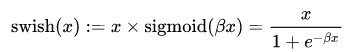

In [15]:
def swish(x):
    return x * torch.sigmoid(x)

## Squeeze and Excitation Networks

For more information see <a href='https://arxiv.org/pdf/1709.01507.pdf'>this paper.</a>

Squeeze-and-Excitation Networks (SENets) introduce a building block for CNNs that improves channel interdependencies at almost no computational cost.

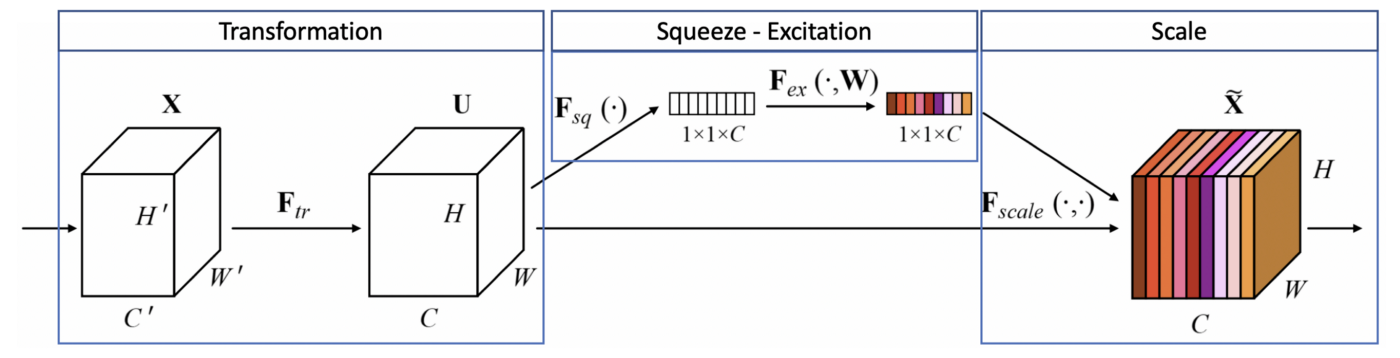
The transformation simply corresponds with the operation that the network where you are going to implement the SE block would perform in its natural scheme. For instance, if you are in a block within a ResNet, the Ftr term will correspond with the process of the entire residual block (convolution, batch normalization, ReLU…). 

The squeezing step is probably the most simply one. It basically performs a average pooling at each channel to create a 1x1 squeezed representation of the volume U.

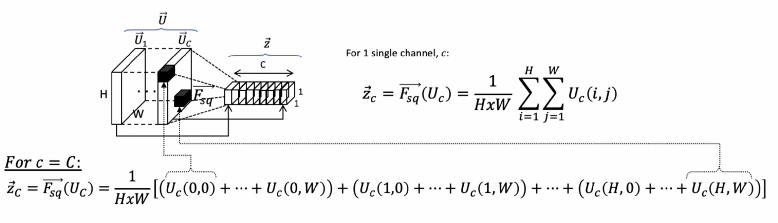

The authors introduce a new parameter called the reduction ratio r, to introduce a first fully connected (FC) layer with a ReLU activation, before the gating network with the sigmoid activation.

The reason to do this is to introduce a bottleneck that allows us to reduce the dimensionality at the same time that introduce new non-linearities.

Furthermore, we can have better control on the model complexity and aid the generalization property of the network.

Having two FC layers will result on having 2 matrices of weights that will be learned by the network during the training in an end-to-end fashion (all of them are backpropagated together with the convolutional kernels).

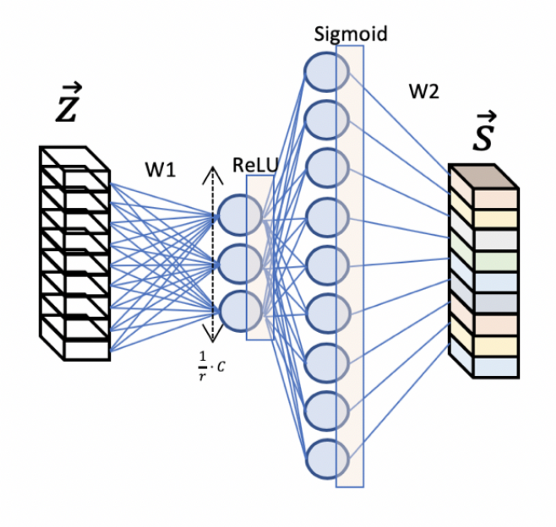

The mathematical expression for this function results then:

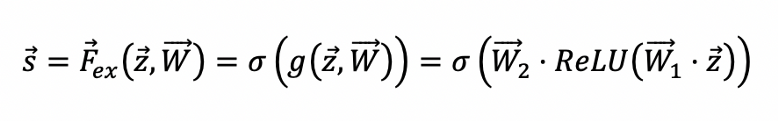

The last step, scaling, is indeed a re-scaling operation. We are going to give the squeezed vector its original shape, keeping the information obtained during the excitation step.

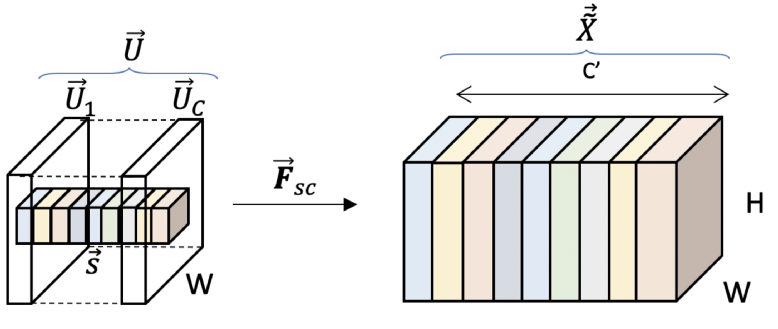
Mathematically, the scaling is achieved by simple scalar product of each channel on the input volume with the corresponding channel on the activated 1x1 squeezed vector.

In [16]:
class SE(nn.Module):
    def __init__(self, nChannels, reductionRatio=2):
        super(SE, self).__init__()
        nChannelReduced = nChannels // reductionRatio
        self.reductionRatio = reductionRatio
        self.fc1 = nn.Linear(nChannels, nChannelReduced, bias=True)
        self.fc2 = nn.Linear(nChannelReduced, nChannels, bias=True)
        self.relu = nn.ReLU()
        self.sigmoid = nn.Sigmoid()

    def forward(self, inputTensor):
        batchSize, nChannels, H, W = inputTensor.size()
        # Reshaping
        squeezeTensor = inputTensor.view(batchSize, nChannels, -1).mean(dim=2)
        fc1Out = self.relu(self.fc1(squeezeTensor))
        fc2Out = self.sigmoid(self.fc2(fc1Out))

        a, b = squeezeTensor.size()
        outputTensor = torch.mul(inputTensor, fc2Out.view(a, b, 1, 1))
        return outputTensor

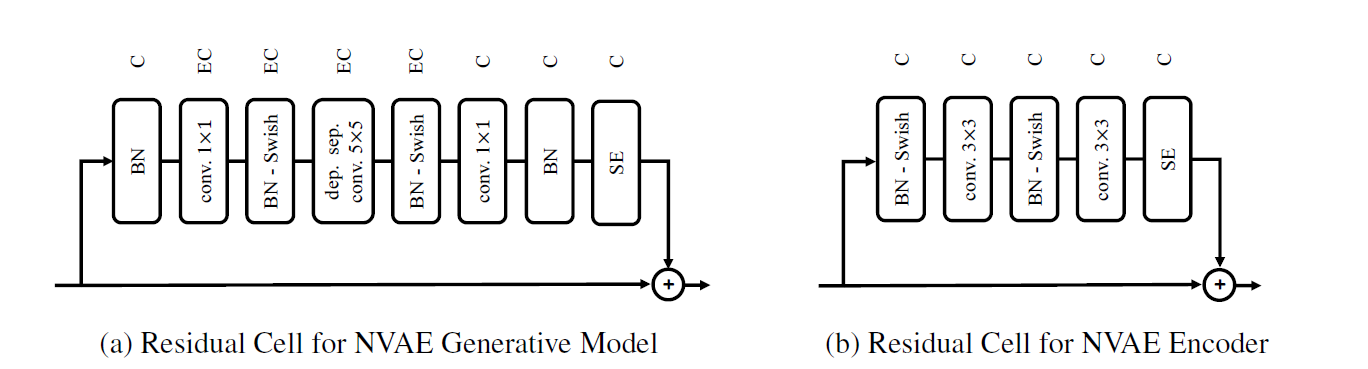

In [44]:
class DecoderRes(nn.Module):
  def __init__(self, inChannel):
    super(DecoderRes, self).__init__()
    self.bn1 = nn.BatchNorm2d(inChannel)
    self.conv1 = nn.Conv2d(in_channels=inChannel,out_channels=2*inChannel,kernel_size=1,stride=1,padding=0)
    self.bn2 = nn.BatchNorm2d(2*inChannel)
    self.dep1 = DepthWiseSeprableConv(inSize=2*inChannel,kernelPerLayer=3,outSize=2*inChannel)
    self.bn3 = nn.BatchNorm2d(2*inChannel)
    self.conv2 = nn.Conv2d(in_channels=2*inChannel,out_channels=inChannel,kernel_size=1,stride=1,padding=0)
    self.bn4 = nn.BatchNorm2d(inChannel)
    self.SE = SE(inChannel)
  def forward(self,x):
    y = self.conv1(self.bn1(x))
    y = swish(self.bn2(y))
    y = self.dep1(y)
    y = swish(self.bn3(y))
    y = self.bn4(self.conv2(y))
    y = self.SE(y)
    return y + x

In [40]:
class EncoderRes(nn.Module):
  def __init__(self,inChannel):
    super(EncoderRes,self).__init__()
    self.bn1 = nn.BatchNorm2d(inChannel)
    self.conv1 = nn.Conv2d(in_channels=inChannel,out_channels=2*inChannel,kernel_size=3,stride=1,padding=1)
    self.bn2 = nn.BatchNorm2d(2*inChannel)
    self.conv2 = nn.Conv2d(in_channels=2*inChannel,out_channels=inChannel,kernel_size=3,stride=1,padding=1)
    self.bn3 = nn.BatchNorm2d(inChannel)
    self.SE = SE(inChannel)
  def forward(self,x):
    y = self.conv1(swish(self.bn1(x)))
    y = self.conv2(swish(self.bn2(y)))
    y = self.SE(y)
    return y + x

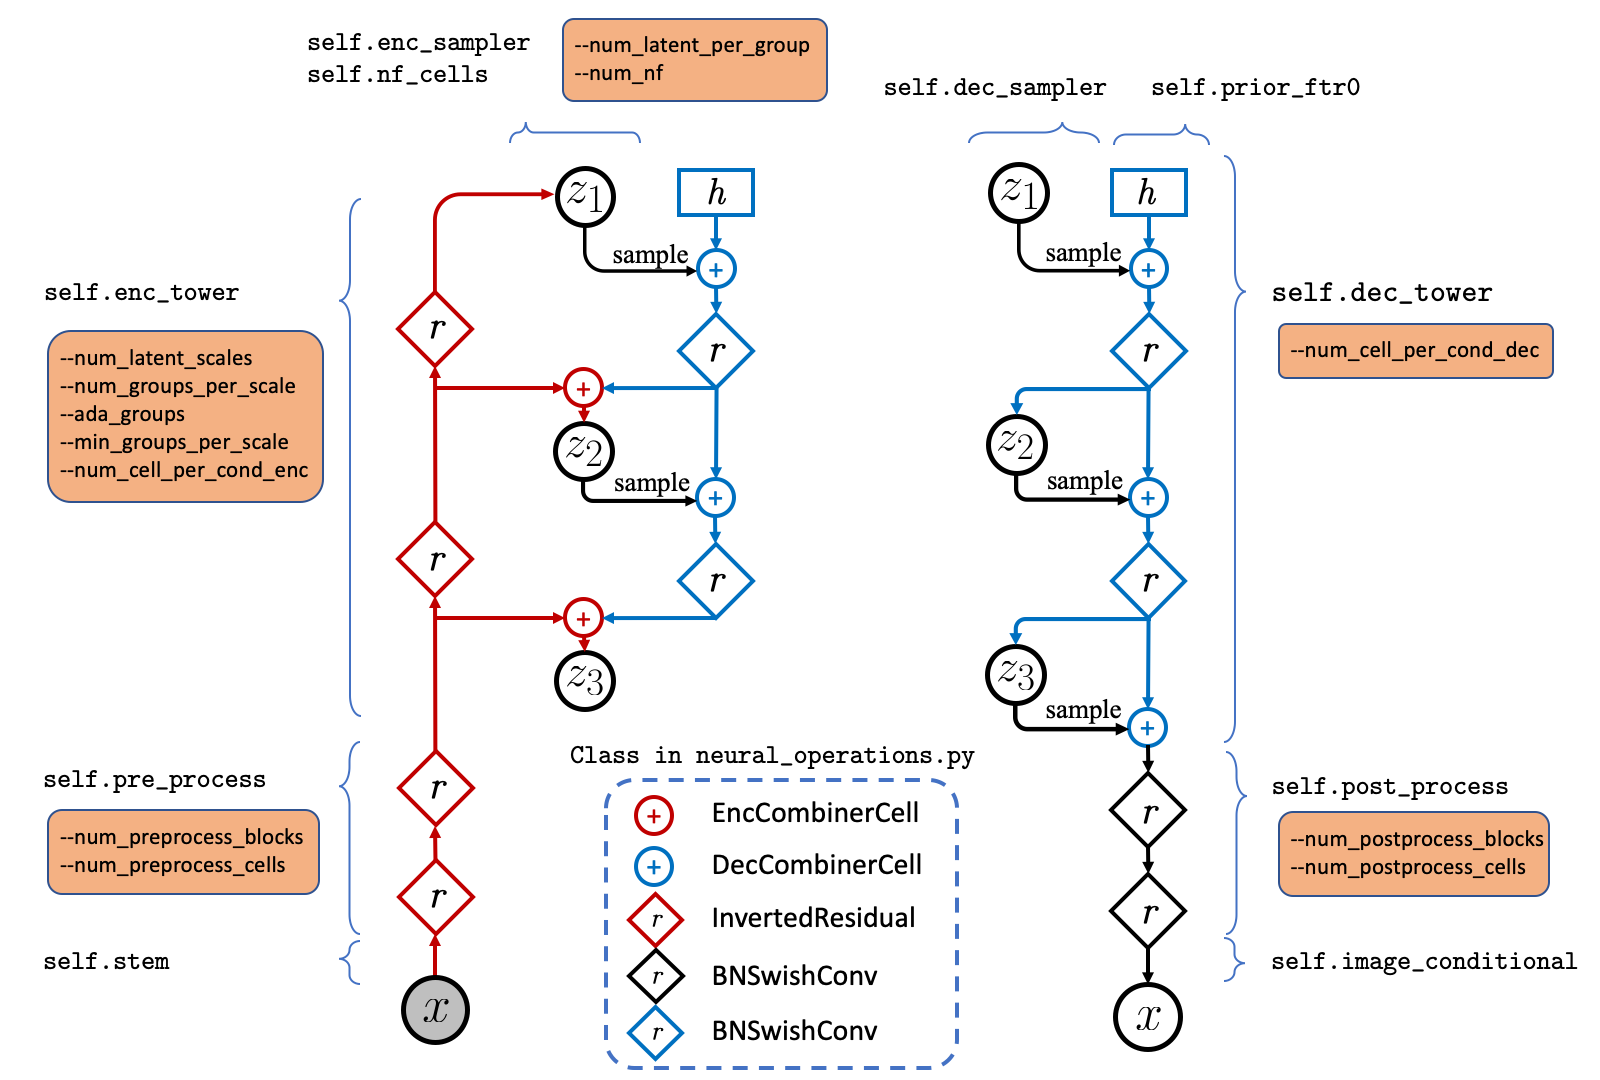

In [29]:
class NVAE(nn.Module):
  def __init__(self, inChannel, originialDim):
    super(NVAE, self).__init__()
    self.originialDim = originialDim
    self.conv1 = nn.Conv2d(in_channels=inChannel,out_channels=8,kernel_size=3,stride=1,padding=1)
    self.encoder1 = EncoderRes(8)
    self.dsconv1 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.encoder2 = EncoderRes(8)
    self.dsconv2 = nn.Conv2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)

    self.qmu1 = nn.Linear(originialDim*originialDim*2,originialDim*originialDim*2)
    self.qvar1 = nn.Linear(originialDim*originialDim*2,originialDim*originialDim*2)
    
    self.qmu0 = nn.Linear(originialDim*originialDim//2,originialDim*originialDim//2)
    self.qvar0 = nn.Linear(originialDim*originialDim//2,originialDim*originialDim//2)

    self.pmu1 = nn.Linear(originialDim*originialDim*2,originialDim*originialDim*2)
    self.pvar1 = nn.Linear(originialDim*originialDim*2,originialDim*originialDim*2)

    self.decoder1 = DecoderRes(8)
    self.usconv1 = nn.ConvTranspose2d(in_channels=8,out_channels=8,kernel_size=2,stride=2,padding=0)
    self.decoder2 = DecoderRes(16)
    self.usconv2 = nn.ConvTranspose2d(in_channels=16,out_channels=16,kernel_size=2,stride=2,padding=0)
    self.decoder3 = DecoderRes(16)
    self.finconv = nn.Conv2d(in_channels=16,out_channels=inChannel,kernel_size=3,stride=1,padding=1)
  
  def forward(self, x):
    z1 = self.dsconv1(self.encoder1(self.conv1(x)))
    z0 = self.dsconv2(self.encoder2(z1))

    qmu0 = self.qmu0(z0.reshape(z0.shape[0],self.originialDim*self.originialDim//2))
    qvar0 = self.qvar0(z0.reshape(z0.shape[0],self.originialDim*self.originialDim//2))

    qmu1 = self.qmu1(z1.reshape(z1.shape[0],self.originialDim*self.originialDim*2))
    qvar1 = self.qvar1(z1.reshape(z1.shape[0],self.originialDim*self.originialDim*2))

    stdvar0 = qvar0.mul(0.5).exp_()
    stdvar1 = qvar1.mul(0.5).exp_()

    e0 = torch.randn(qmu0.shape).to(device)
    ez0 = qmu0+e0*stdvar0
    ez0 = ez0.reshape(ez0.shape[0],8,self.originialDim//4,self.originialDim//4)
    ez1 = self.usconv1(self.decoder1(ez0))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.originialDim*self.originialDim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.originialDim*self.originialDim*2))

    pstdvar1 = pvar1.mul(0.5).exp_()

    e2 = torch.randn(qmu1.shape).to(device)
    ez2 = pmu1+qmu1 + e2*pstdvar1*stdvar1
    ez2 = ez2.reshape(ez2.shape[0],8,self.originialDim//2,self.originialDim//2)
    
    final = torch.cat((ez1,ez2),1)

    recons = nn.Sigmoid()(self.finconv(self.decoder3(self.usconv2(self.decoder2(final)))))

    return qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons

  def sample(self, bs):
    e = torch.randn([bs,8,self.originialDim//4,self.originialDim//4]).to(device)
    ez1 = self.usconv1(self.decoder1(e))

    pmu1 = self.pmu1(ez1.reshape(ez1.shape[0],self.originialDim*self.originialDim*2))
    pvar1 = self.pvar1(ez1.reshape(ez1.shape[0],self.originialDim*self.originialDim*2))

    stdvar1 = pvar1.mul(0.5).exp_()

    e1 = torch.randn([ez1.shape[0],self.originialDim*self.originialDim*2]).to(device)
    e1 = pmu1 + e1*stdvar1
    e1 = e1.reshape(e1.shape[0],8,self.originialDim//2,self.originialDim//2)
    recons = nn.Sigmoid()(self.finconv(self.decoder3(self.usconv2(self.decoder2(torch.cat((ez1,e1),1))))))

    return recons

  def loss(self, x):
    qmu0,qvar0,qmu1,qvar1,pmu1,pvar1,recons = self.forward(x)
    klz0 = 0.5 * torch.sum(torch.square(qmu0) + qvar0.exp() - qvar0-1) / x.shape[0]
    klz1 = 0.5 * torch.sum(torch.square(qmu1) / pvar1.exp() + qvar1.exp() - qvar1 - 1)
    reconsloss = nn.BCELoss()(recons,x)
    return klz0,klz1,reconsloss

In [35]:
batch_size=64
epochs=50

In [22]:
transform = transforms.Compose([transforms.ToTensor()])

In [24]:
train = torchvision.datasets.MNIST(root='data/mnist',
                                           train=True, 
                                           transform=transform,
                                           download=True)

test = torchvision.datasets.MNIST(root='data/mnist',
                                          train=False, 
                                          transform=transform)

trainLoader = torch.utils.data.DataLoader(dataset=train,
                                           batch_size=batch_size, 
                                           shuffle=True)

testLoader = torch.utils.data.DataLoader(dataset=test,
                                          batch_size=batch_size, 
                                          shuffle=True)

In [45]:
model = NVAE(1, 28).to(device)

AdaMax is a generalisation of Adam from `l2` the norm `l∞` to the norm.

```
torch.optim.Adamax(params, lr=0.002, betas=(0.9, 0.999), eps=1e-08, weight_decay=0)
```

Implements Adamax algorithm (a variant of Adam based on infinity norm).

In page 14 of the paper it says:
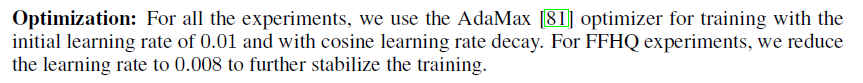

In [36]:
optim = torch.optim.Adamax(model.parameters())

epoch: 0 kl0_loss: 1074.0965718098957 recons_loss: 0.6978037202835083 kl1_loss: 1074.0965718098957
epoch: 1 kl0_loss: 1074.0653398111979 recons_loss: 0.6978050751050313 kl1_loss: 1074.0653398111979
epoch: 2 kl0_loss: 1074.0904372395833 recons_loss: 0.6978264677365621 kl1_loss: 1074.0904372395833
epoch: 3 kl0_loss: 1074.1251356445312 recons_loss: 0.6977957027435303 kl1_loss: 1074.1251356445312
epoch: 4 kl0_loss: 1074.1187250976564 recons_loss: 0.6978018412907918 kl1_loss: 1074.1187250976564
epoch: 5 kl0_loss: 1074.0748147135416 recons_loss: 0.6978167036056518 kl1_loss: 1074.0748147135416
epoch: 6 kl0_loss: 1074.0880028645834 recons_loss: 0.6977796637852987 kl1_loss: 1074.0880028645834
epoch: 7 kl0_loss: 1074.0628544270833 recons_loss: 0.6977990055720011 kl1_loss: 1074.0628544270833
epoch: 8 kl0_loss: 1074.0607103515624 recons_loss: 0.6977920473734538 kl1_loss: 1074.0607103515624
epoch: 9 kl0_loss: 1074.107984765625 recons_loss: 0.697814808400472 kl1_loss: 1074.107984765625
epoch: 10 kl0

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:24: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


epoch: 20 kl0_loss: 1074.0360219726563 recons_loss: 0.6977913003603617 kl1_loss: 1074.0360219726563
epoch: 21 kl0_loss: 1074.0963155598959 recons_loss: 0.6978100942611695 kl1_loss: 1074.0963155598959
epoch: 22 kl0_loss: 1074.1164637695313 recons_loss: 0.6978012376149495 kl1_loss: 1074.1164637695313
epoch: 23 kl0_loss: 1074.0745763997395 recons_loss: 0.6978011795361837 kl1_loss: 1074.0745763997395
epoch: 24 kl0_loss: 1074.0931727213542 recons_loss: 0.6977891834894816 kl1_loss: 1074.0931727213542
epoch: 25 kl0_loss: 1074.0829525390625 recons_loss: 0.6977839128176371 kl1_loss: 1074.0829525390625
epoch: 26 kl0_loss: 1074.0930134440105 recons_loss: 0.697817434310913 kl1_loss: 1074.0930134440105
epoch: 27 kl0_loss: 1074.1035135091147 recons_loss: 0.6978187803586324 kl1_loss: 1074.1035135091147
epoch: 28 kl0_loss: 1074.0931412760417 recons_loss: 0.6978004283905029 kl1_loss: 1074.0931412760417
epoch: 29 kl0_loss: 1074.0711232421875 recons_loss: 0.6977812820752461 kl1_loss: 1074.0711232421875
e

<Figure size 432x288 with 0 Axes>

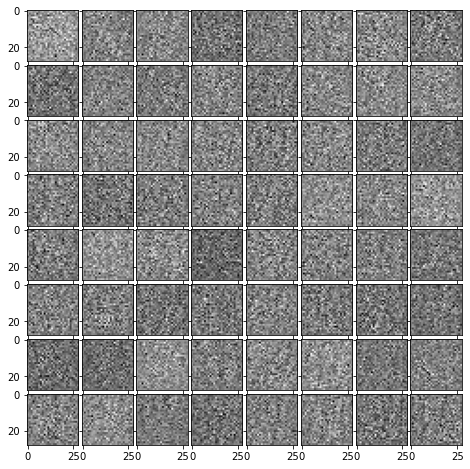

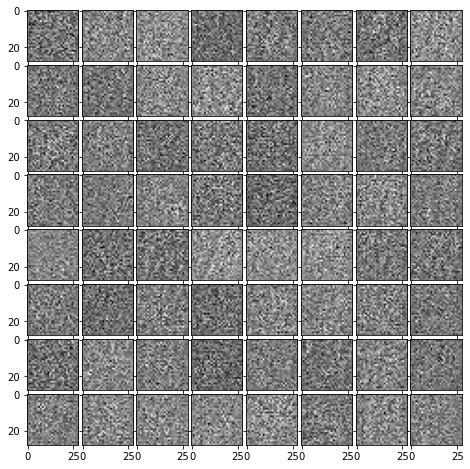

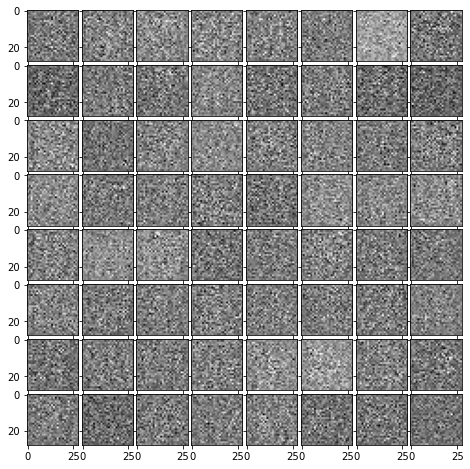

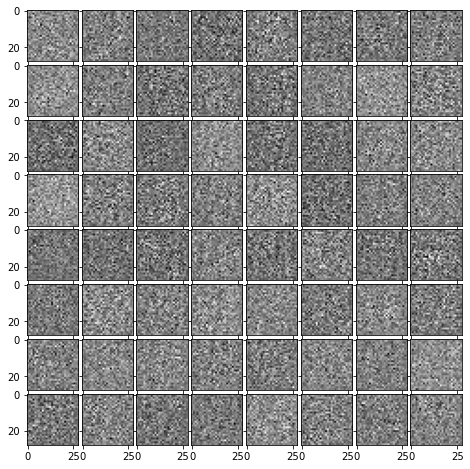

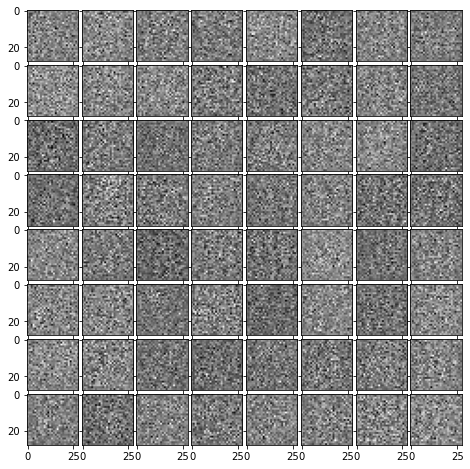

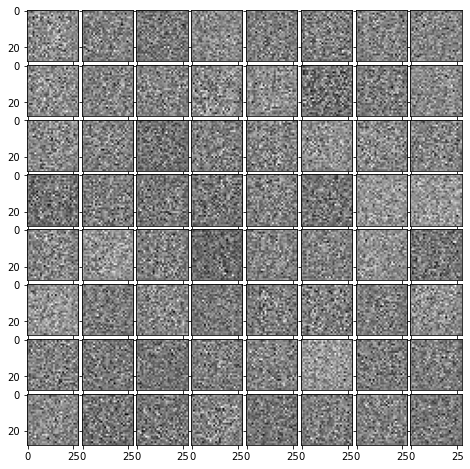

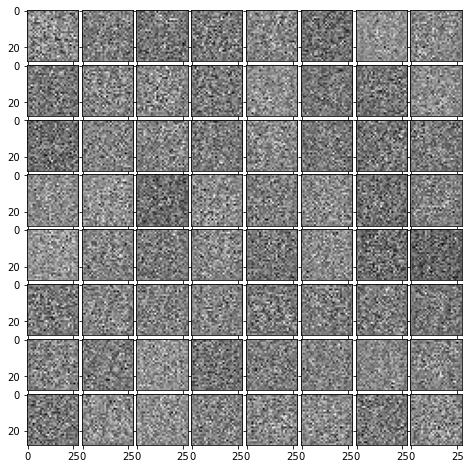

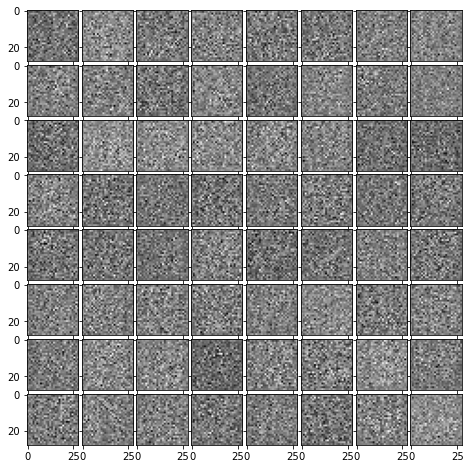

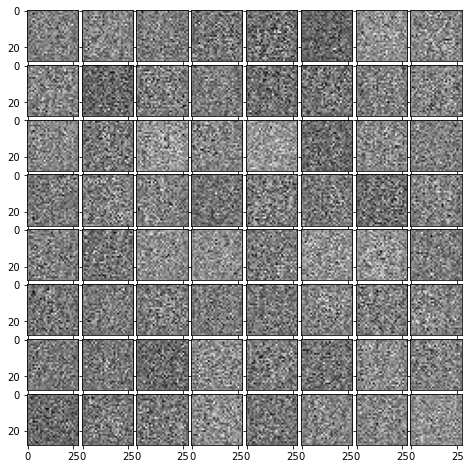

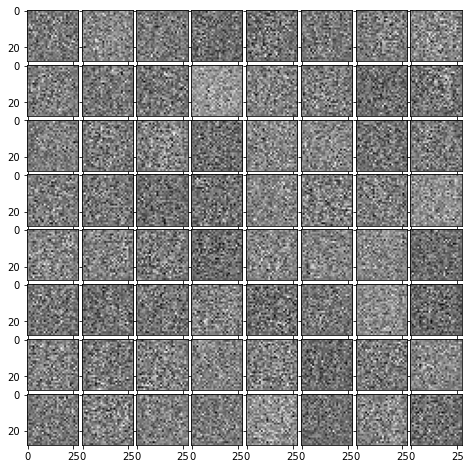

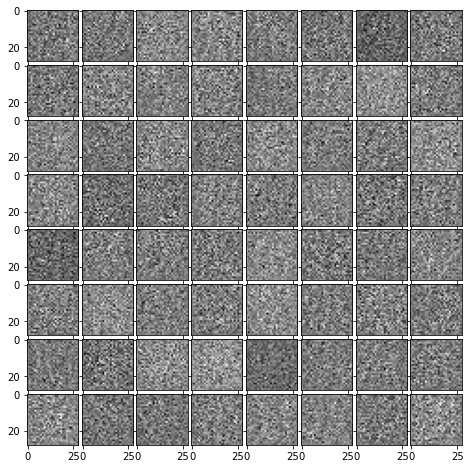

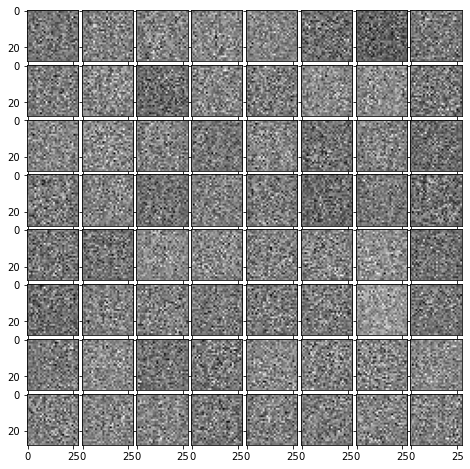

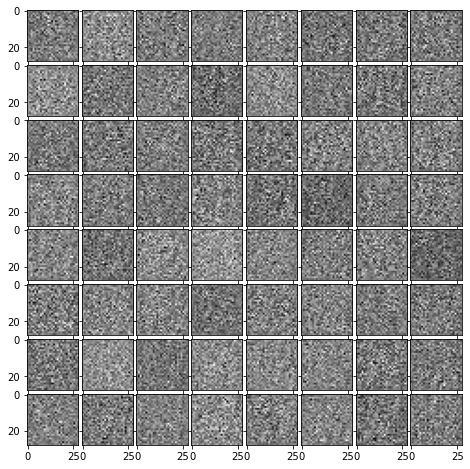

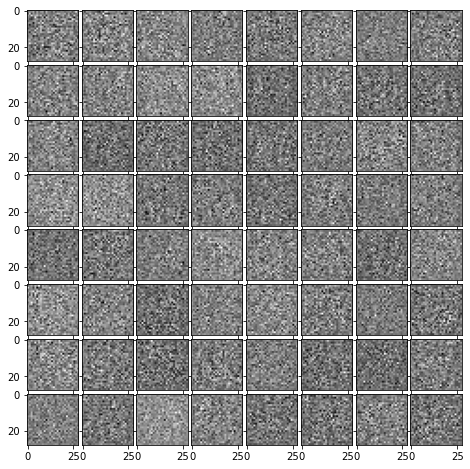

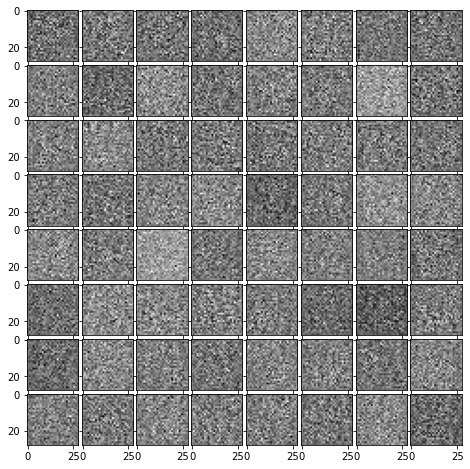

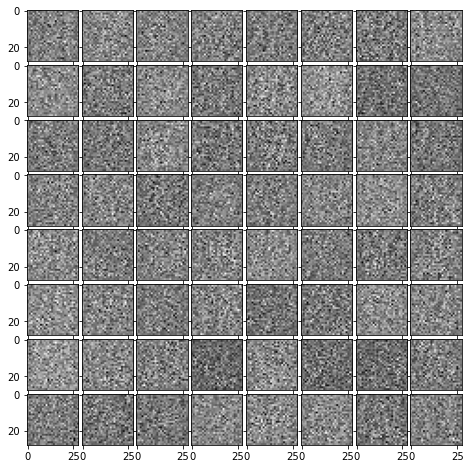

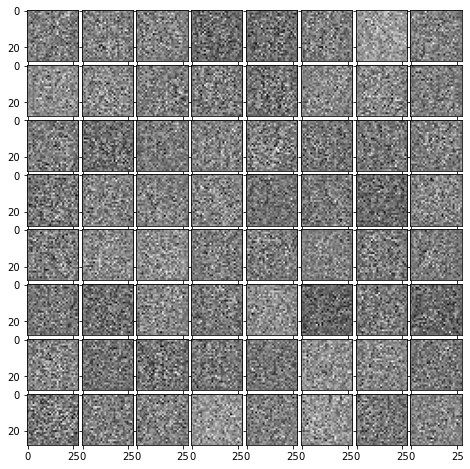

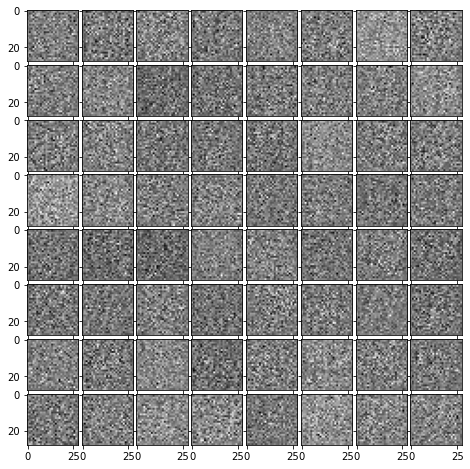

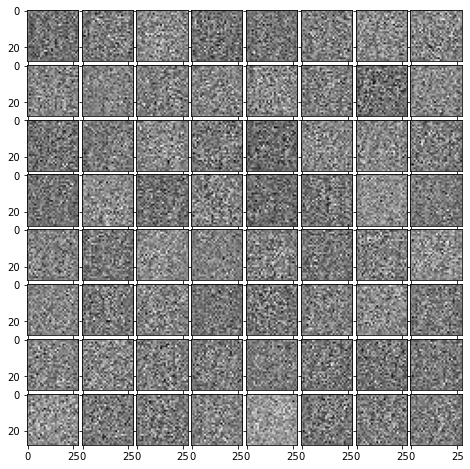

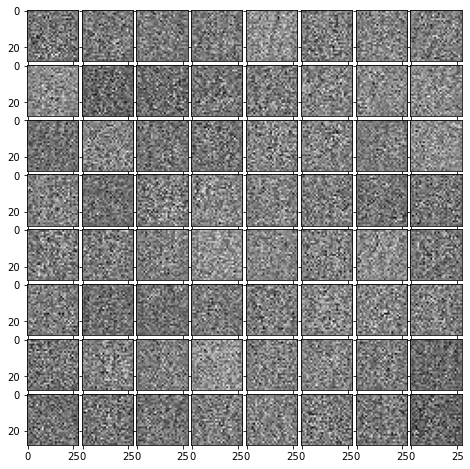

Error in callback <function flush_figures at 0x7f0fc8ffd4d0> (for post_execute):


KeyboardInterrupt: 

In [50]:
for epoch in range(epochs):
    minLoss = 1
    runningKL0Loss=0
    runningReconsLoss=0
    runningKL1Loss=0
    numImages=0
    
    for i,(img, label) in enumerate(trainLoader):
      img = img.to(device)      
      optim.zero_grad()
      klz0, klz1, recons = model.loss(img)
      loss = recons + epoch * 0.001 * klz0 + epoch * 0.0001 * klz1
      loss.backward()
      optim.step()
      runningKL0Loss = runningKL0Loss + klz0.item()*len(img)
      runningKL1Loss = runningKL1Loss + klz1.item()*len(img)
      runningReconsLoss = runningReconsLoss + recons.item()*len(img)
      numImages= numImages+len(img)
        
    print('epoch: '+str(epoch)+' kl0_loss: '+str(runningKL1Loss/numImages)+' recons_loss: '+str(runningReconsLoss/numImages)+' kl1_loss: '+str(runningKL1Loss/numImages))
    
    imgs = model.sample(64).cpu().detach().reshape(64, 28, 28)
    plt.gray()
    fig = plt.figure(figsize=(8., 8.))
    grid = ImageGrid(fig, 111,  # similar to subplot(111)
                    nrows_ncols=(8, 8),  # creates 2x2 grid of axes
                    axes_pad=0.05)  # pad between axes in inch.

    for ax, im in zip(grid, imgs):
        # Iterating over the grid returns the Axes.
        ax.imshow(im)
    plt.savefig(str(epoch)+".png")